In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../bioAI.mplstyle")
import torch

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size

In [2]:
model = HexagonalGCs(ncells=3)
def plane_waves(model,r):
    activity = torch.cos((r[:, None] - model.phases[None]) @ model.ks.T)
    #activity = torch.sum(activity, axis=-1)  # sum plane waves
    activity = (2 / 3) * (activity / 3 + 0.5)  # Solstad2006 scaling
    #activity = self.relu(activity) if self.relu else activity
    return activity.detach().numpy(), torch.sum(activity, axis=-1).detach().numpy()

In [18]:
res = 200
rs = np.mgrid[-1:1:complex(res),-1:1:complex(res)].reshape(2,-1).T
rs_t = torch.tensor(rs,dtype=torch.float32)
activity, g = plane_waves(model,rs_t)
activity.shape, rs_t.shape

((40000, 3, 3), torch.Size([40000, 2]))

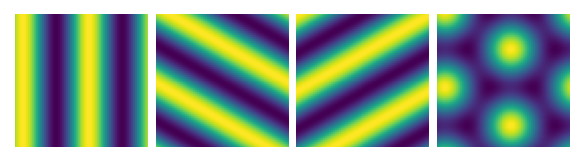

In [19]:
figsize = set_size(fraction=1,mode='square')
fig,axs = plt.subplots(ncols=4,figsize=figsize)
axs[0].imshow(activity[:,0,0].reshape(res,res).T,origin='lower')
axs[1].imshow(activity[:,0,1].reshape(res,res).T,origin='lower')
axs[2].imshow(activity[:,0,2].reshape(res,res).T,origin='lower')
axs[3].imshow(g[:,0].reshape(res,res).T,origin='lower')
[ax.axis('off') for ax in axs];
plt.subplots_adjust(wspace=0.06,hspace=0)